# Teste do modelo de prognóstico (HI + ARIMA + probabilidade de falha)

Este notebook aplica o modelo treinado em **prognose_treino** para:

1. **Carregar** autoencoder e scaler salvos
2. **Calcular o HI** (MSE de reconstrução) para uma janela de teste (últimas **w** amostras do cluster)
3. **Ajustar ARIMA** à série de HI e **prever** HI futuro
4. **Calcular probabilidade de falha** (kernel de resíduos + HI_limit)

**Pré-requisito**: Executar antes o `prognose_treino.ipynb` para gerar `dados/autoencoder_unit3.h5`, `dados/scaler.pkl` e `dados/HI_limit.txt`.

## 1. Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm
from scipy.special import inv_boxcox
from scipy.special import boxcox as sp_boxcox
from scipy.stats import boxcox, shapiro, norm
from scipy.special import boxcox as boxcox_scalar
from keras.models import load_model
import joblib




## 2. Carregar modelo e scaler

Carrega o autoencoder e o MinMaxScaler salvos no treino (mesmo usado para normalizar as entradas).

In [2]:
# Load autoencoder and scaler
autoencoder = load_model("dados/autoencoder.h5", compile=False, safe_mode=False)
scaler = joblib.load("dados/scaler.pkl")


2026-02-11 13:27:40.336222: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4 Pro
2026-02-11 13:27:40.336252: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2026-02-11 13:27:40.336255: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.88 GB
2026-02-11 13:27:40.336270: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2026-02-11 13:27:40.336278: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## 3. Carregar dados e janela de teste

Carrega `dados/dados.csv`, filtra por **cluster** e usa as **últimas w** amostras (`tail(w)`) como janela de teste (em contraste com o treino, que usa as primeiras w).

In [3]:
# Load data
df = pd.read_csv("dados/dados.csv")



In [4]:
cluster = 1
w =  10

df= df[df["Cluster"] == cluster]

# Pegar os primeiros 10 pontos (Amostra 1 a 10)
df =  df.tail(w)
df


,Cluster,Amostra,S1,S2,S3,S4
90,1,91,12.777,22.281,31.992,40.958
91,1,92,13.280,22.392,32.168,41.484
92,1,93,12.527,22.227,30.871,41.459
93,1,94,12.799,22.714,31.353,41.386
94,1,95,12.758,21.996,31.460,41.072
95,1,96,13.175,22.696,31.488,41.390
96,1,97,13.052,22.523,31.484,41.274
97,1,98,12.509,22.755,32.739,41.455
98,1,99,12.326,22.721,32.447,41.929
99,1,100,13.049,22.659,32.028,41.716


## 4. Calcular HI (MSE por amostra)

Prepara a matriz de features (S1–S4), normaliza com o **mesmo scaler** do treino, passa pelo autoencoder e calcula o **MSE** entre entrada e reconstrução por amostra. Esse MSE é o **Health Index (HI)** de cada ponto.

In [5]:
# Prepare data for autoencoder (exclude 'sample' column)
features = [col for col in df.columns if col != 'Amostra' and col != 'Cluster']
X = df[features].values

# Scale data using the same scaler from training
X_scaled = scaler.transform(X)

# Reconstruct using autoencoder
X_pred = autoencoder.predict(X_scaled, verbose=0)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
2026-02-11 13:27:40.601541: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


In [6]:

# Calculate MSE per sample
mse_per_sample = np.mean(np.square(X_scaled - X_pred), axis=1)

In [7]:
# Scale data using the same scaler from training
X_scaled = scaler.transform(X)

# Reconstruct using autoencoder
X_pred = autoencoder.predict(X_scaled, verbose=0)

# Calculate MSE per sample
mse_per_sample = np.mean(np.square(X_scaled - X_pred), axis=1)

samples = np.arange(len(mse_per_sample))  # or use your real sample index
df_mse = pd.DataFrame({
    "sample": samples,
    "mse": mse_per_sample
})

df_mse


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


,sample,mse
0,0,20.682406
1,1,27.636483
2,2,13.436939
3,3,19.196921
4,4,14.976009
5,5,21.845939
6,6,19.753984
7,7,34.117478
8,8,31.359623
9,9,27.541167


## 5. ARIMA — preparação e escolha de (p, d, q)

A série de HI (MSE por amostra) é usada para prever o comportamento futuro:

- **Box–Cox**: deixa a série mais próxima da normalidade (valores positivos).
- **ADF**: teste de estacionariedade para definir **d** (0 ou 1).
- **auto_arima**: escolhe **p** e **q** por AIC.

In [8]:
# --------------------------------------------------
# STEP 1: Prepare data
# --------------------------------------------------
error_series = df_mse["mse"].dropna().reset_index(drop=True).astype(float)

In [9]:
# Ensure all values are positive for Box-Cox
if np.any(error_series <= 0):
    error_series = error_series - np.min(error_series) + 1e-6

# --------------------------------------------------
# STEP 2: Apply Box–Cox transformation
# --------------------------------------------------
transformed, lambda_bc = boxcox(error_series)
print(f"Box–Cox λ = {lambda_bc:.4f}")

Box–Cox λ = 0.3417


In [10]:
# --------------------------------------------------
# STEP 3: ADF test → determine d
# --------------------------------------------------
adf_result = adfuller(transformed)
p_val = adf_result[1]
d = 0 if p_val < 0.05 else 1
print(f"ADF p-value = {p_val:.4f} → d = {d}")

ADF p-value = 0.3001 → d = 1


In [11]:

# --------------------------------------------------
# STEP 4: Auto ARIMA to select p, d, q
# --------------------------------------------------
model_auto = pm.auto_arima(
    transformed,
    start_p=0, start_q=0,
    max_p=5, max_q=5,
    d=d,
    seasonal=False,
    stepwise=True,
    information_criterion='aic',
    suppress_warnings=True
)



p, d, q = model_auto.order
print(f"Selected (p, d, q) = {model_auto.order}")
print(model_auto.summary())

Selected (p, d, q) = (0, 1, 0)
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   10
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 -13.287
Date:                Wed, 11 Feb 2026   AIC                             28.574
Time:                        13:27:40   BIC                             28.772
Sample:                             0   HQIC                            28.149
                                 - 10                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         1.1217      0.661      1.698      0.089      -0.173       2.416
Ljung-Box (L1) (Q):                   4.38   Jarque-Bera (JB):                 0.35
Prob(Q):        

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/pytho

## 6. HI_limit e previsão ARIMA

- **HI_limit**: lido de `dados/HI_limit.txt` (calculado no treino). Limite acima do qual se considera risco de falha.
- **Previsão**: ARIMA prevê os próximos **n_forecast** passos no domínio Box–Cox; depois aplica **inv_boxcox** para voltar ao domínio HI. Também obtém os valores *fitted* (ajuste in-sample).

In [12]:
with open("dados/HI_limit.txt") as f:
    HI_lim = float(f.read().strip())
print(f"HI_lim = {HI_lim}")

HI_lim = 1.440989


In [13]:
# ================================================
# STEP 5 — Forecast (in transformed domain) + invert Box–Cox to ORIGINAL domain
# ================================================
n_forecast = 5
fc_bc, ci_bc = model_auto.predict(n_periods=n_forecast, return_conf_int=True, alpha=0.05)

# Back to ORIGINAL HI domain
fc_mean = inv_boxcox(fc_bc, lambda_bc)
fc_lower = inv_boxcox(ci_bc[:, 0], lambda_bc)
fc_upper = inv_boxcox(ci_bc[:, 1], lambda_bc)

# Also get in-sample fitted values in ORIGINAL domain
fitted_bc = model_auto.predict_in_sample()
fitted = inv_boxcox(fitted_bc, lambda_bc)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


## 7. Resíduos e domínio para probabilidade de falha

- **Resíduos** = HI observado − valor ajustado pelo ARIMA (domínio original).
- **Shapiro–Wilk**: se os resíduos não forem normais, o kernel e o limiar são aplicados no domínio Box–Cox.
- **HI_thr_dom**: HI_limit no mesmo domínio (original ou transformado) em que será calculada a probabilidade.

In [14]:
# Series in ORIGINAL (HI) domain
y = df_mse["mse"].dropna().reset_index(drop=True).astype(float)

# Ensure positivity for Box–Cox on the HI series (safety)
if np.any(y <= 0):
    y = y - np.min(y) + 1e-6


In [15]:
# ================================================
# STEP 6 — Compute RESIDUALS in ORIGINAL domain
#           (yellow points are fits; residuals = real - fit)
# ================================================
residuals = y.values - fitted  # ORIGINAL (HI) domain residuals


In [16]:
# STEP 7 — Normality check of residuals
#          If not normal, work in the Box–Cox (transformed) domain for kernel & threshold
# ================================================
sh_stat, sh_p = shapiro(residuals)
print(f"Shapiro-Wilk: stat={sh_stat:.4f}, p={sh_p:.4f}")

use_transformed_kernel = sh_p <= 0.05  # non-normal → transform per PDF guidance

# Prepare domain-specific objects:
if use_transformed_kernel:
    # Residuals must be positive to apply Box–Cox; shift them minimally
    res_shift = residuals - residuals.min() + 1e-6
    res_dom = sp_boxcox(res_shift, lambda_bc)               # kernel domain (transformed)
    # Transform forecasts and threshold to the same domain
    fc_mean_dom  = sp_boxcox(fc_mean,  lambda_bc)
    fc_lower_dom = sp_boxcox(fc_lower, lambda_bc)
    fc_upper_dom = sp_boxcox(fc_upper, lambda_bc)
else:
    # Use ORIGINAL domain directly
    res_dom = residuals
    fc_mean_dom  = fc_mean
    fc_lower_dom = fc_lower
    fc_upper_dom = fc_upper


Shapiro-Wilk: stat=0.9598, p=0.7837


In [17]:
# Threshold in the working domain
HI_thr_dom = sp_boxcox(HI_lim, lambda_bc) if use_transformed_kernel else HI_lim


## 8. Probabilidade de falha (kernel de resíduos)

Para cada passo de previsão **t**:

- **a_t**, **b_t**: escala e translação do kernel de resíduos usando o intervalo de confiança da previsão.
- **Kernel ajustado**: \(X_i^{(t)} = a_t \varepsilon_i + b_t\) (resíduos no domínio de trabalho).
- **P(falha | t)** = 1 − ECDF_t(HI_threshold): probabilidade de o HI futuro superar o limite.

In [18]:
from statsmodels.distributions.empirical_distribution import ECDF

# ================================================
# STEP 9 — Build the residual-kernel failure probability per step t
#           Using equations (2)–(5) from your PDF:
#   (2) a_t = (Q_upper,t - Q_lower,t) / (q97.5 - q2.5)
#   (3) b_t = mean_ARIMA,t - a_t * mean_residuals
#   (4) X_i^(t) = a_t * ε_i + b_t
#   (5) P_fail(t) = 1 - ECDF_t(HI_threshold)
# ================================================
q975 = np.percentile(res_dom, 97.5)
q025 = np.percentile(res_dom, 2.5)
res_mean = np.mean(res_dom)

p_fail = []
adj_means = []  # optional: mean of adjusted kernel at each t (should equal fc_mean_dom)
for mean_t, low_t, up_t in zip(fc_mean_dom, fc_lower_dom, fc_upper_dom):
    # --- (2) Scale factor a_t ---
    denom = (q975 - q025) if (q975 - q025) != 0 else 1e-9
    a_t = (up_t - low_t) / denom  # :contentReference[oaicite:2]{index=2}

    # --- (3) Translation b_t to align means ---
    b_t = mean_t - a_t * res_mean  # :contentReference[oaicite:3]{index=3}

    # --- (4) Adjusted kernel for this step ---
    adjusted = a_t * res_dom + b_t  # :contentReference[oaicite:4]{index=4}

    # --- (5) Failure probability against threshold ---
    ecdf = ECDF(adjusted)
    p = 1.0 - ecdf(HI_thr_dom)      # :contentReference[oaicite:5]{index=5}
    p_fail.append(p)
    adj_means.append(np.mean(adjusted))

p_fail = np.array(p_fail)
adj_means = np.array(adj_means)

In [19]:
# ================================================
# STEP 9 — Build the residual-kernel failure probability per step t
#           Using equations (2)–(5) from your PDF:
#   (2) a_t = (Q_upper,t - Q_lower,t) / (q97.5 - q2.5)
#   (3) b_t = mean_ARIMA,t - a_t * mean_residuals
#   (4) X_i^(t) = a_t * ε_i + b_t
#   (5) P_fail(t) = 1 - ECDF_t(HI_threshold)
# ================================================
q975 = np.percentile(res_dom, 97.5)
q025 = np.percentile(res_dom, 2.5)
res_mean = np.mean(res_dom)

p_fail = []
adj_means = []  # optional: mean of adjusted kernel at each t (should equal fc_mean_dom)
for mean_t, low_t, up_t in zip(fc_mean_dom, fc_lower_dom, fc_upper_dom):
    # --- (2) Scale factor a_t ---
    denom = (q975 - q025) if (q975 - q025) != 0 else 1e-9
    a_t = (up_t - low_t) / denom  # :contentReference[oaicite:2]{index=2}

    # --- (3) Translation b_t to align means ---
    b_t = mean_t - a_t * res_mean  # :contentReference[oaicite:3]{index=3}

    # --- (4) Adjusted kernel for this step ---
    adjusted = a_t * res_dom + b_t  # :contentReference[oaicite:4]{index=4}

    # --- (5) Failure probability against threshold ---
    ecdf = ECDF(adjusted)
    p = 1.0 - ecdf(HI_thr_dom)      # :contentReference[oaicite:5]{index=5}
    p_fail.append(p)
    adj_means.append(np.mean(adjusted))

p_fail = np.array(p_fail)
adj_means = np.array(adj_means)

In [20]:
# ================================================
# STEP 10 — Pack results into a DataFrame (ORIGINAL domain for readability)
# ================================================
# Future sample indices
future_samples = np.arange(w, w + n_forecast)

# If we worked in transformed domain, show ORIGINAL-domain means/intervals for the table/plot:
out_df = pd.DataFrame({
    "sample": future_samples,
    "mean": fc_mean,              # ORIGINAL domain
    "lower_95": fc_lower,         # ORIGINAL domain
    "upper_95": fc_upper,         # ORIGINAL domain
    "p_fail": p_fail              # Probability computed in the correct domain internally
})
print(out_df.head())

   sample       mean   lower_95   upper_95  p_fail
0      10  27.541167  12.894305  50.286753     1.0
1      11  27.541167   8.792731  62.482178     0.9
2      12  27.541167   6.308633  73.055193     0.9
3      13  27.541167   4.615502  82.832245     0.9
4      14  27.541167   3.398752  92.127852     0.9


## 9. Gráficos

- **(A)** HI observado (autoencoder), valores ajustados pelo ARIMA e previsão com IC 95%.
- **(B)** Probabilidade de falha por ciclo previsto (acima de HI_limit).

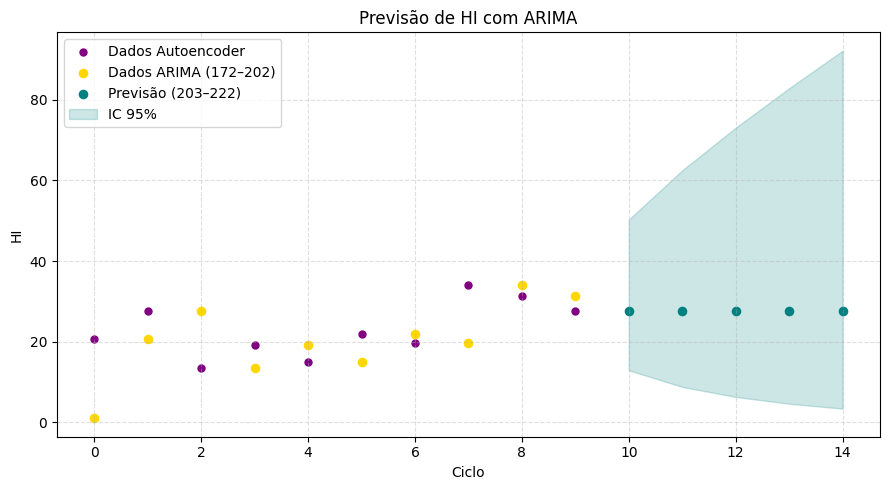

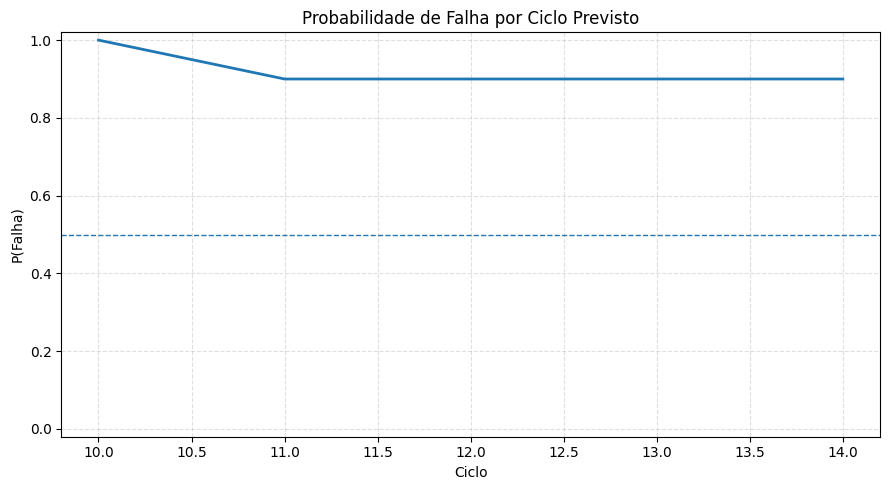

In [21]:
# ================================================
# STEP 11 — Plots
# ================================================
# (A) Observed vs. Fitted vs. Forecast
plt.figure(figsize=(9, 5))
# Raw autoencoder points (full)
plt.scatter(df_mse["sample"], df_mse["mse"], color="purple", s=25, label="Dados Autoencoder")

# Fitted (yellow) on 172–202
plt.scatter(df_mse["sample"], fitted, color="gold", s=35, label="Dados ARIMA (172–202)")

# Forecast mean and CI (teal)
plt.scatter(future_samples, fc_mean, color="teal", s=35, label="Previsão (203–222)")
plt.fill_between(future_samples, fc_lower, fc_upper, color="teal", alpha=0.2, label="IC 95%")

plt.title("Previsão de HI com ARIMA", fontsize=12)
plt.xlabel("Ciclo"); plt.ylabel("HI")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()

# (B) Probability of failure curve
plt.figure(figsize=(9, 5))
plt.plot(future_samples, p_fail, linewidth=2)
plt.axhline(0.5, ls="--", lw=1)  # optional reference at 50%
plt.ylim(-0.02, 1.02)
plt.title("Probabilidade de Falha por Ciclo Previsto")
plt.xlabel("Ciclo"); plt.ylabel("P(Falha)")
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()